# FINAL: Customer Segmentation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import squarify
from datetime import datetime
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from underthesea import word_tokenize, pos_tag, sent_tokenize
import jieba
import re
import string

In [2]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=DeprecationWarning)

## 1. Data Preparing

In [4]:
df_product = pd.read_csv('Data/Products_with_Prices.csv')
df = pd.read_csv('Data/Transactions.csv')

In [5]:
df_product.head()

productId       productName     price
0          1    tropical fruit  7.803532
1          2        whole milk  1.800000
2          3         pip fruit  3.000000
3          4  other vegetables  0.800000
4          5        rolls/buns  1.200000

In [6]:
df = df.merge(df_product, how='left', on='productId')

In [7]:
df['Sales'] = df['items'] * df['price']
df['Transaction_id'] = df.index

In [8]:
df.head()

Member_number        Date  productId  items       productName     price  \
0           1808  21-07-2015          1      3    tropical fruit  7.803532   
1           2552  05-01-2015          2      1        whole milk  1.800000   
2           2300  19-09-2015          3      3         pip fruit  3.000000   
3           1187  12-12-2015          4      3  other vegetables  0.800000   
4           3037  01-02-2015          2      1        whole milk  1.800000   

       Sales  Transaction_id  
0  23.410597               0  
1   1.800000               1  
2   9.000000               2  
3   2.400000               3  
4   1.800000               4

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38765 entries, 0 to 38764
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Member_number   38765 non-null  int64  
 1   Date            38765 non-null  object 
 2   productId       38765 non-null  int64  
 3   items           38765 non-null  int64  
 4   productName     38765 non-null  object 
 5   price           38765 non-null  float64
 6   Sales           38765 non-null  float64
 7   Transaction_id  38765 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 2.7+ MB


In [10]:
string_to_date = lambda x : datetime.strptime(x, "%d-%m-%Y").date()

# Convert InvoiceDate from object to datetime format
df['Date'] = df['Date'].apply(string_to_date)
df['Date'] = df['Date'].astype('datetime64[ns]')

In [11]:
df['Year'] = df['Date'].dt.year
df['Year'] = df['Year'].astype(str)

In [12]:
# Check duplicate
df.duplicated().sum()

0

In [13]:
# Check null
df.isnull().sum()

Member_number     0
Date              0
productId         0
items             0
productName       0
price             0
Sales             0
Transaction_id    0
Year              0
dtype: int64

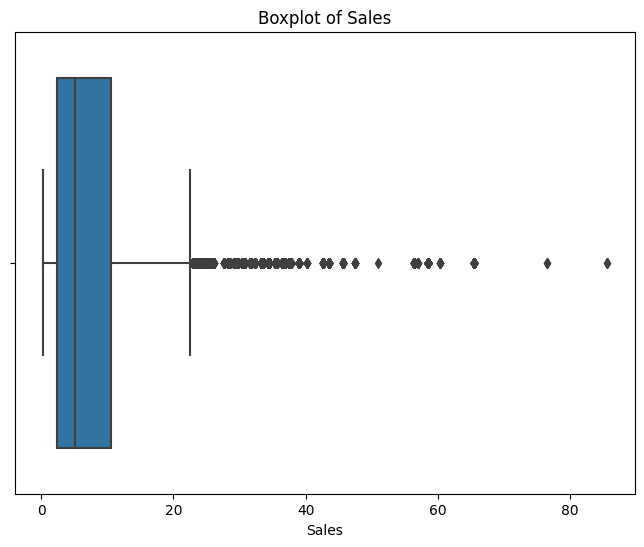

In [14]:
# Check outlier of SALES
plt.figure(figsize=(8, 6))
sns.boxplot(x='Sales', data=df)
plt.xlabel('Sales')
plt.title('Boxplot of Sales')
plt.show()

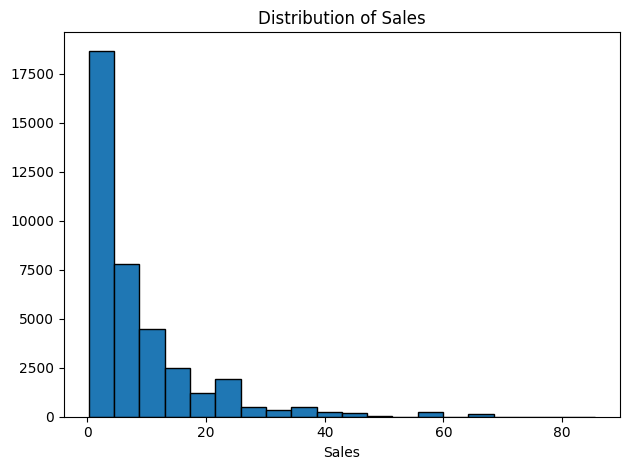

In [15]:
# Vẽ phân phối của 'Sales'
plt.hist(df['Sales'], bins = 20, edgecolor = 'black') #Chọn số lượng bins phù hợp
plt.title('Distribution of Sales')
plt.xlabel('Sales')

plt.tight_layout()
plt.show()

In [16]:
mm_scaler = MinMaxScaler()
df['Sales_scaled'] = mm_scaler.fit_transform(df[['Sales']])

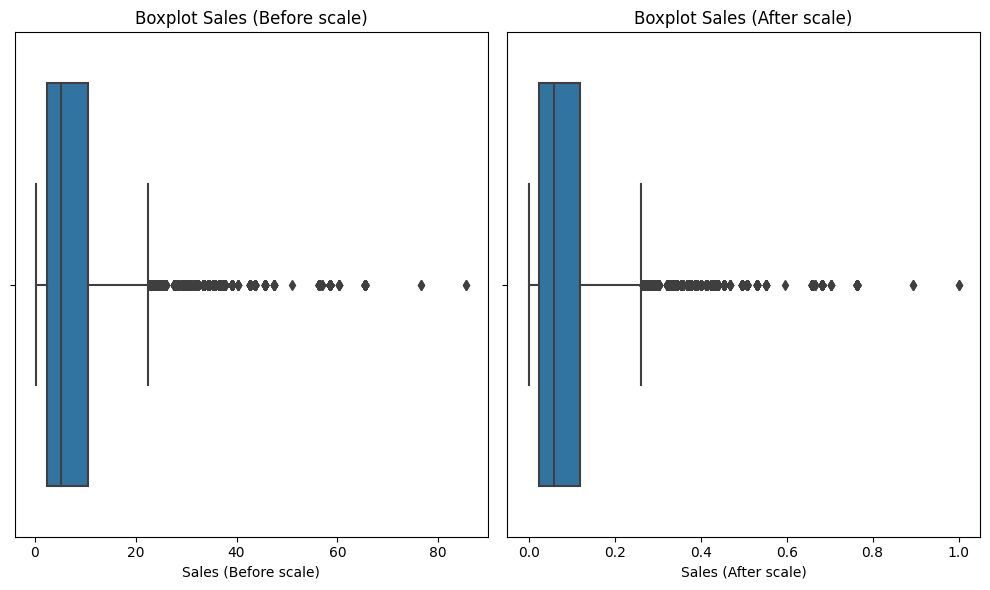

In [17]:
plt.figure(figsize=(10, 6))

# Boxplot trước khi áp dụng scaler
plt.subplot(1, 2, 1)
sns.boxplot(x='Sales', data=df)
plt.xlabel('Sales (Before scale)')
plt.title('Boxplot Sales (Before scale)')

# Boxplot sau khi áp dụng scaler
plt.subplot(1, 2, 2)
sns.boxplot(x='Sales_scaled', data=df)
plt.xlabel('Sales (After scale)')
plt.title('Boxplot Sales (After scale)')

plt.tight_layout()
plt.show()

In [18]:
# Drop NA values
df = df.dropna()

In [19]:
# Print DataFrame
df.head()

Member_number       Date  productId  items       productName     price  \
0           1808 2015-07-21          1      3    tropical fruit  7.803532   
1           2552 2015-01-05          2      1        whole milk  1.800000   
2           2300 2015-09-19          3      3         pip fruit  3.000000   
3           1187 2015-12-12          4      3  other vegetables  0.800000   
4           3037 2015-02-01          2      1        whole milk  1.800000   

       Sales  Transaction_id  Year  Sales_scaled  
0  23.410597               0  2015      0.271251  
1   1.800000               1  2015      0.017606  
2   9.000000               2  2015      0.102113  
3   2.400000               3  2015      0.024648  
4   1.800000               4  2015      0.017606

In [20]:
df.tail()

Member_number       Date  productId  items            productName  \
38760           4471 2014-10-08         76      2          sliced cheese   
38761           2022 2014-02-23         65      3                  candy   
38762           1097 2014-04-16        154      2               cake bar   
38763           1510 2014-12-03         12      3  fruit/vegetable juice   
38764           1521 2014-12-26        104      3               cat food   

       price  Sales  Transaction_id  Year  Sales_scaled  
38760    4.2    8.4           38760  2014      0.095070  
38761    3.6   10.8           38761  2014      0.123239  
38762    2.4    4.8           38762  2014      0.052817  
38763    2.1    6.3           38763  2014      0.070423  
38764   11.2   33.6           38764  2014      0.390845

## 2. Data Understanding

In [21]:
print('THÔNG TIN LẦN MUA HÀNG CÓ GIÁ TRỊ CAO NHẤT')
df.loc[df['Sales'].idxmax()]

THÔNG TIN LẦN MUA HÀNG CÓ GIÁ TRỊ CAO NHẤT


Member_number                    1654
Date              2015-03-25 00:00:00
productId                         139
items                               3
productName                    whisky
price                            28.5
Sales                            85.5
Transaction_id                   3373
Year                             2015
Sales_scaled                      1.0
Name: 3373, dtype: object

In [22]:
start_date = df['Date'].min()
end_date = df['Date'].max()

print(f"Các thông tin mua hàng đang được ghi nhận từ {start_date} đến {end_date}")

Các thông tin mua hàng đang được ghi nhận từ 2014-01-01 00:00:00 đến 2015-12-30 00:00:00


In [23]:
df_g_product = df.groupby('productName').agg({'Member_number': lambda x: len(x.unique()), 'Transaction_id': lambda x: len(x.unique())}).reset_index()
df_g_product.columns = ['Sản phẩm', 'Số lượng KH', 'Số lượng đơn hàng']
df_g_product.sort_values(by = 'Số lượng KH', ascending = False, inplace = True)
df_g_product.reset_index(drop=True, inplace=True)
df_g_product.head()

Sản phẩm  Số lượng KH  Số lượng đơn hàng
0        whole milk         1786               2502
1  other vegetables         1468               1898
2        rolls/buns         1363               1716
3              soda         1222               1514
4            yogurt         1103               1334

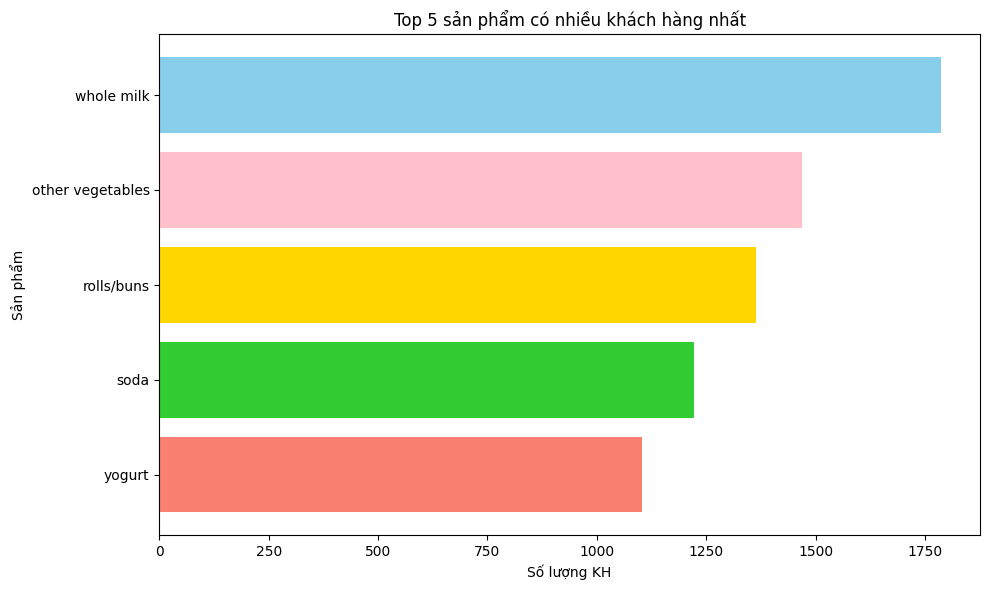

In [24]:
# Biểu đồ Top số lượng KH theo sản phẩm
df_bar = df_g_product.head()
colors = ['salmon', 'limegreen','gold', 'pink','skyblue']
sorted_indices = sorted(range(len(df_bar['Số lượng KH'])), key=lambda i: df_bar['Số lượng KH'][i], reverse=False)
sorted_top = [df_bar['Sản phẩm'][i] for i in sorted_indices]
sorted_num_top = [df_bar['Số lượng KH'][i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(sorted_top, sorted_num_top, color=colors)
plt.xlabel('Số lượng KH')
plt.ylabel('Sản phẩm')
plt.title('Top 5 sản phẩm có nhiều khách hàng nhất')
plt.tight_layout()
plt.show()

In [25]:
STOP_WORD_FILE = 'Data/stopwords-en.txt'
with open(STOP_WORD_FILE, 'r', encoding='utf-8') as file:
    stop_words = file.read()

stop_words = stop_words.split('\n')

In [26]:
def wcloud_visualize(df,column):
    word = []
    for t in column:
        word.append(t)
    text = pd.Series(word).str.cat(sep=' ')
    
    wc = WordCloud(
                max_words=300,
                width=1600,
                height=900,
                max_font_size=400)
    wc.generate(text)
    
    plt.figure(figsize=(8,12))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

Top sản phẩm được mua nhiều nhất tại cửa hàng


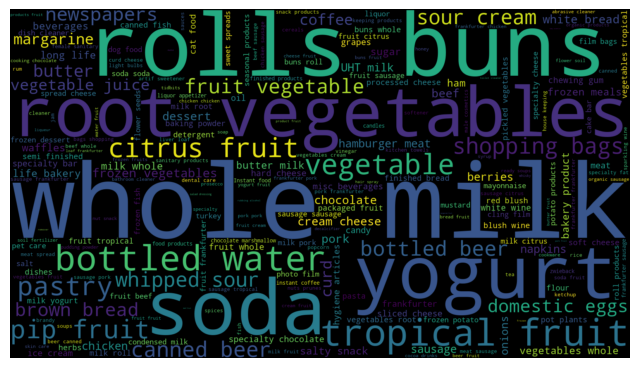

In [27]:
print('Top sản phẩm được mua nhiều nhất tại cửa hàng')
wcloud_visualize(df, df['productName'])

In [28]:
df_plot = df.groupby('Year').agg({'Member_number': lambda x: len(x.unique()),
                                             'Transaction_id': lambda x: len(x.unique())
                                              }).reset_index()
df_plot.columns = ['Năm', 'Số lượng KH', 'Số lượng đơn hàng']

df_plot.sort_values(by = 'Số lượng KH', ascending = False, inplace = True)
df_plot.reset_index(drop=True, inplace=True)
df_plot

Năm  Số lượng KH  Số lượng đơn hàng
0  2014         3443              18277
1  2015         3314              20488

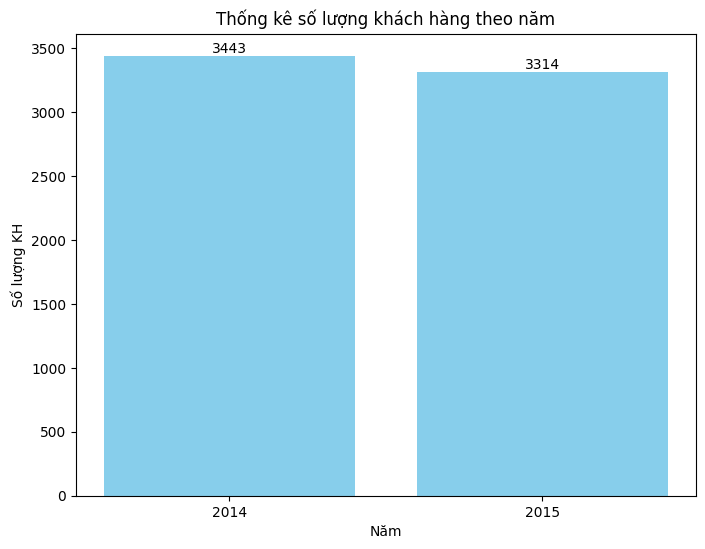

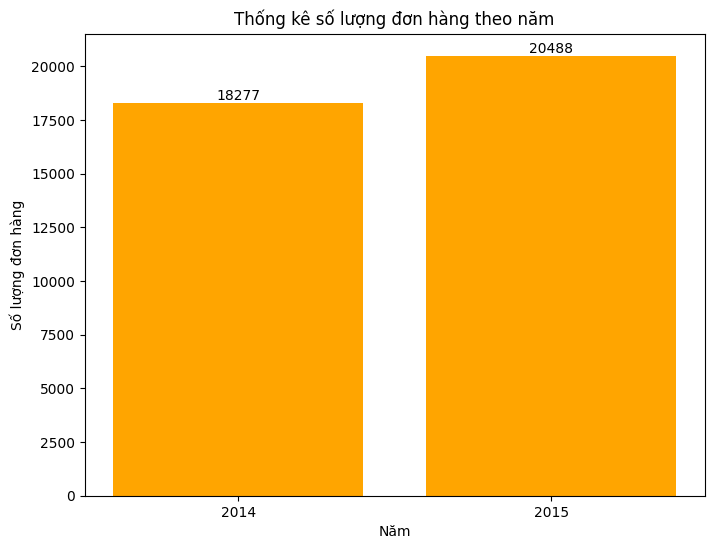

In [29]:
# Vẽ biểu đồ số lượng mua theo năm
plt.figure(figsize=(8, 6))
bars = plt.bar(df_plot['Năm'], df_plot['Số lượng KH'], color='skyblue')
plt.xlabel('Năm')
plt.ylabel('Số lượng KH')
plt.title('Thống kê số lượng khách hàng theo năm')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{height}', ha='center', va='bottom')
plt.show()

# Vẽ biểu đồ giá trị mua theo năm
plt.figure(figsize=(8, 6))
bars2 = plt.bar(df_plot['Năm'], df_plot['Số lượng đơn hàng'], color='orange')
plt.xlabel('Năm')
plt.ylabel('Số lượng đơn hàng')
plt.title('Thống kê số lượng đơn hàng theo năm')
for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{height}', ha='center', va='bottom')
plt.show()

In [30]:
# Let’s take a closer look at the data we will need to manipulate.
print('Transactions timeframe from {} to {}'.format(df['Date'].min(), df['Date'].max()))
print('{:,} transactions don\'t have a customer id'.format(df[df.Member_number.isnull()].shape[0]))
print('{:,} unique customer_id'.format(len(df.Member_number.unique())))

Transactions timeframe from 2014-01-01 00:00:00 to 2015-12-30 00:00:00
0 transactions don't have a customer id
3,898 unique customer_id


## 3. Modeling & Evaluation

## RFM

### Create RFM analysis for each customers

In [31]:
# RFM
# Convert string to date, get max date of dataframe
max_date = df['Date'].max().date()

Recency = lambda x : (max_date - x.max().date()).days
Frequency  = lambda x: len(x.unique())
Monetary = lambda x : round(sum(x), 2)

df_RFM = df.groupby('Member_number').agg({'Date': Recency,
                                        'Transaction_id': Frequency,
                                        'Sales': Monetary })

In [32]:
df_RFM.head()

Date  Transaction_id   Sales
Member_number                              
1000             35              13   53.80
1001            242              12  100.00
1002            122               8   70.31
1003            323               8   60.65
1004             28              21  204.97

In [33]:
# Rename the columns of DataFrame
df_RFM.columns = ['Recency', 'Frequency', 'Monetary']
# Descending Sorting
df_RFM = df_RFM.sort_values('Monetary', ascending=False)

In [34]:
df_RFM.head()

Recency  Frequency  Monetary
Member_number                              
2433                 3         31    375.31
2193                91         27    361.45
1793                26         25    345.10
3289                 4         29    334.17
2743               142         17    312.47

In [35]:
df_RFM.shape

(3898, 3)

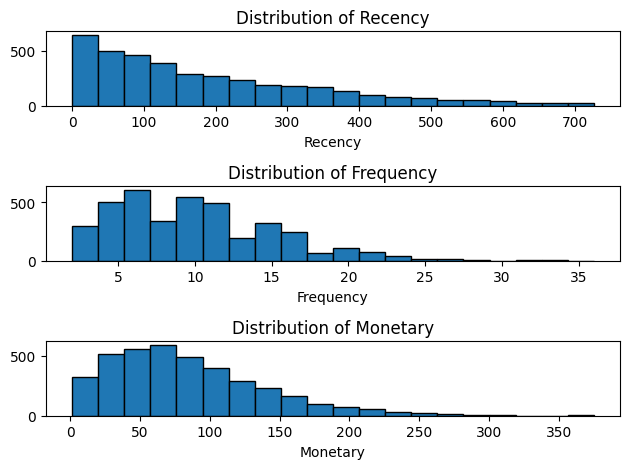

In [36]:
# Vẽ phân phối của 'Recency'
plt.subplot(3, 1, 1) # 3 hàng, 1 cột, vị trí thứ nhất
plt.hist(df_RFM['Recency'], bins=20, edgecolor='black') # Chọn số lượng bins phù hợp
plt.title('Distribution of Recency')
plt.xlabel('Recency')

# Vẽ phân phối của 'Frequency'
plt.subplot(3, 1, 2) # 3 hàng, 1 cột, vị trí thứ hai
plt.hist(df_RFM['Frequency'], bins=20, edgecolor='black') # Chọn số lượng bins phù hợp
plt.title('Distribution of Frequency')
plt.xlabel('Frequency')

# Vẽ phân phối của 'Monetary'
plt.subplot(3, 1, 3) # 3 hàng, 1 cột, vị trí thứ ba
plt.hist(df_RFM['Monetary'], bins=20, edgecolor='black') # Chọn số lượng bins phù hợp
plt.title('Distribution of Monetary')
plt.xlabel('Monetary')

plt.tight_layout()
plt.show()

### Calculate RFM quartiles

In [37]:
# Create labels for Recency, Frequency, Monetary
r_labels = range(4, 0, -1) # số ngày tính từ lần cuối mua hàng lớn thì gán nhãn nhỏ, ngược lại thì nhãn lớn
f_labels = range(1, 5)
m_labels = range(1, 5)

In [38]:
[*r_labels]

[4, 3, 2, 1]

In [39]:
# Assign these labels to 4 equal percentile groups
r_groups = pd.qcut(df_RFM['Recency'].rank(method='first'), q=4, labels=r_labels)

f_groups = pd.qcut(df_RFM['Frequency'].rank(method='first'), q=4, labels=f_labels)

m_groups = pd.qcut(df_RFM['Monetary'].rank(method='first'), q=4, labels=m_labels)

In [40]:
# Create new columns R, F, M
df_RFM = df_RFM.assign(R = r_groups.values, F = f_groups.values,  M = m_groups.values)
df_RFM.head()

Recency  Frequency  Monetary  R  F  M
Member_number                                       
2433                 3         31    375.31  4  4  4
2193                91         27    361.45  3  4  4
1793                26         25    345.10  4  4  4
3289                 4         29    334.17  4  4  4
2743               142         17    312.47  2  4  4

### Concat RFM quartile values to create RFM Segments

In [41]:
def join_rfm(x): return str(int(x['R'])) + str(int(x['F'])) + str(int(x['M']))
df_RFM['RFM_Segment'] = df_RFM.apply(join_rfm, axis=1)

In [42]:
df_RFM.head()

Recency  Frequency  Monetary  R  F  M RFM_Segment
Member_number                                                   
2433                 3         31    375.31  4  4  4         444
2193                91         27    361.45  3  4  4         344
1793                26         25    345.10  4  4  4         444
3289                 4         29    334.17  4  4  4         444
2743               142         17    312.47  2  4  4         244

#### Count num of unique segments

In [43]:
rfm_count_unique = df_RFM.groupby('RFM_Segment')['RFM_Segment'].nunique()

In [44]:
print(rfm_count_unique.sum())

60


- Having 60 different segments using the concatenate method quickly becomes unwieldy for any practical use. We will need a more concise way to define our segments.

#### Calculate RFM score and level

In [45]:
# Calculate RFM_Score
df_RFM['RFM_Score'] = df_RFM[['R','F','M']].sum(axis=1)
df_RFM.head()

Recency  Frequency  Monetary  R  F  M RFM_Segment  RFM_Score
Member_number                                                              
2433                 3         31    375.31  4  4  4         444         12
2193                91         27    361.45  3  4  4         344         11
1793                26         25    345.10  4  4  4         444         12
3289                 4         29    334.17  4  4  4         444         12
2743               142         17    312.47  2  4  4         244         10

## 3.a. RFM + Manual Segmentation

In [46]:
def rfm_level(df):
    if df['RFM_Score'] == 12:
        return 'VIP'
    elif df['R'] == 4 and df['F'] == 1 and df['M'] == 1:
        return 'NEW'
    elif df['F'] == 4 and df['R'] >= 3:
        return 'LOYAL'
    elif df['F'] == 1:
        return 'TRAVELLER'
    elif df['R'] == 1:
        return 'LOST'
    else:
        return 'REGULARS'

In [47]:
# Create a new column RFM_Level
df_RFM['RFM_Level'] = df_RFM.apply(rfm_level, axis=1)

In [48]:
df_RFM.head()

Recency  Frequency  Monetary  R  F  M RFM_Segment  RFM_Score  \
Member_number                                                                 
2433                 3         31    375.31  4  4  4         444         12   
2193                91         27    361.45  3  4  4         344         11   
1793                26         25    345.10  4  4  4         444         12   
3289                 4         29    334.17  4  4  4         444         12   
2743               142         17    312.47  2  4  4         244         10   

              RFM_Level  
Member_number            
2433                VIP  
2193              LOYAL  
1793                VIP  
3289                VIP  
2743           REGULARS

In [49]:
# Print the header with top 5 rows
df_RFM[::2000]

Recency  Frequency  Monetary  R  F  M RFM_Segment  RFM_Score  \
Member_number                                                                 
2433                 3         31    375.31  4  4  4         444         12   
2360               315          6     73.31  1  1  2         112          4   

               RFM_Level  
Member_number             
2433                 VIP  
2360           TRAVELLER

#### Number of segments

In [50]:
df_RFM['RFM_Level'].value_counts()

REGULARS     1717
TRAVELLER     917
LOST          494
LOYAL         425
VIP           287
NEW            58
Name: RFM_Level, dtype: int64

#### Calculate mean values for each segment

In [51]:
# Calculate average values for each RFM_Level, and return a size of each segment
rfm_agg = df_RFM.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(0)

rfm_agg.columns = rfm_agg.columns.droplevel()
rfm_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg['Percent'] = round((rfm_agg['Count']/rfm_agg.Count.sum())*100, 2)

# Reset the index
rfm_agg = rfm_agg.reset_index()

In [52]:
rfm_agg

RFM_Level  RecencyMean  FrequencyMean  MonetaryMean  Count  Percent
0       LOST        382.0            9.0          75.0    494    12.67
1      LOYAL         79.0           17.0         131.0    425    10.90
2        NEW         22.0            4.0          21.0     58     1.49
3   REGULARS        124.0           10.0          88.0   1717    44.05
4  TRAVELLER        313.0            4.0          39.0    917    23.52
5        VIP         29.0           19.0         177.0    287     7.36

#### TreeMap

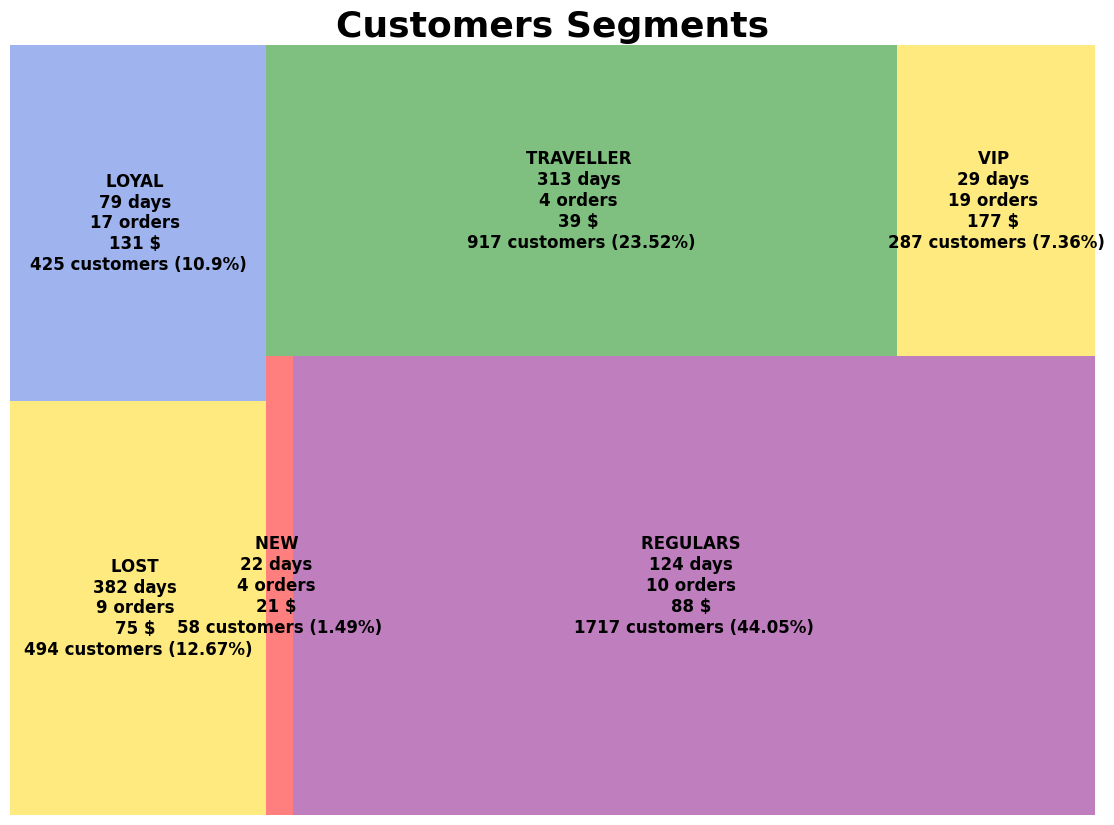

In [53]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict = {'VIP':'gold','TRAVELLER':'royalblue', 'LOST':'red', 'LOYAL':'purple', 'NEW':'green'}

squarify.plot(sizes=rfm_agg['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg.iloc[i])
                      for i in range(0, len(rfm_agg))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')

plt.savefig('RFM Segments.png')
plt.show()

#### Scatter Plot (RFM)

In [54]:
import plotly.express as px

fig = px.scatter(rfm_agg, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="RFM_Level",
           hover_name="RFM_Level", size_max=100)
fig.show()

### Summary:
- Các nhóm phân tách khá rõ, không bị lẫn vào nhau quá nhiều

## 3.b. RFM + KMeans (LDS6)
### Kmeans clusters with the Elbow Method

In [55]:
df_now = df_RFM[['Recency','Frequency','Monetary']]

In [56]:
df_now.head()

Recency  Frequency  Monetary
Member_number                              
2433                 3         31    375.31
2193                91         27    361.45
1793                26         25    345.10
3289                 4         29    334.17
2743               142         17    312.47

In [57]:
df_now.tail()

Recency  Frequency  Monetary
Member_number                              
4565                 0          2       2.2
3949               273          2       2.1
1560               593          2       1.9
1221               410          2       1.7
1250               448          2       1.3

In [58]:
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_now)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



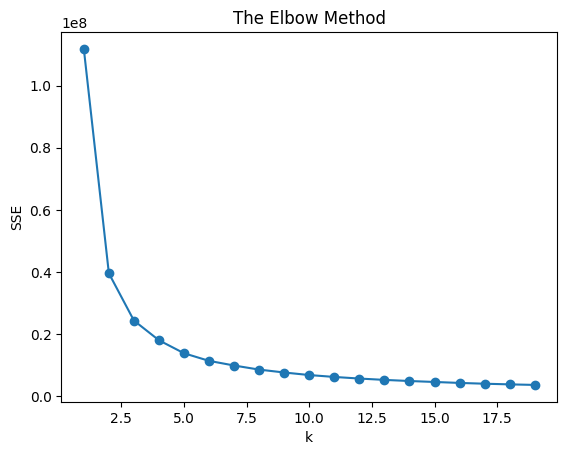

In [59]:
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')

plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.show()

In [60]:
# Build model with k=5
model = KMeans(n_clusters=5, random_state=42)
model.fit(df_now)
model.labels_.shape

C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



(3898,)

In [61]:
df_now["Cluster"] = model.labels_
df_now.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean', 'count']}).round(2)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_11024\1766179631.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0        343.79      7.41    63.32   735
1         54.10      9.65    71.55  1186
2         64.04     17.20   176.01   604
3        187.19      9.55    78.45  1046
4        551.46      4.59    37.91   327

In [62]:
# Calculate average values for each RFM_Level, and return a size of each segment
rfm_agg2 = df_now.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(0)

rfm_agg2.columns = rfm_agg2.columns.droplevel()
rfm_agg2.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg2['Percent'] = round((rfm_agg2['Count']/rfm_agg2.Count.sum())*100, 2)

# Reset the index
rfm_agg2 = rfm_agg2.reset_index()

# Change thr Cluster Columns Datatype into discrete values
rfm_agg2['Cluster'] = 'Cluster '+ rfm_agg2['Cluster'].astype('str')

# Print the aggregated dataset
rfm_agg2

Cluster  RecencyMean  FrequencyMean  MonetaryMean  Count  Percent
0  Cluster 0        344.0            7.0          63.0    735    18.86
1  Cluster 1         54.0           10.0          72.0   1186    30.43
2  Cluster 2         64.0           17.0         176.0    604    15.50
3  Cluster 3        187.0           10.0          78.0   1046    26.83
4  Cluster 4        551.0            5.0          38.0    327     8.39

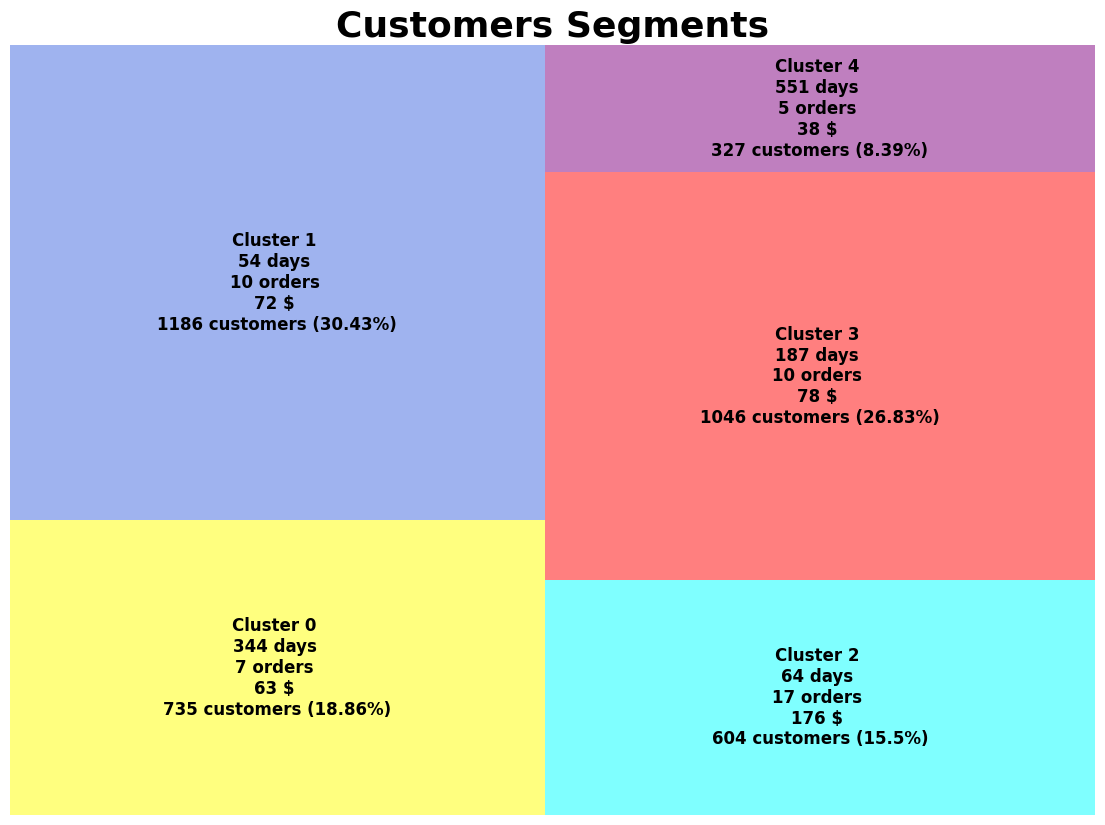

In [63]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict2 = {'Cluster0':'yellow','Cluster1':'royalblue', 'Cluster2':'cyan',
               'Cluster3':'red', 'Cluster4':'purple', 'Cluster5':'green', 'Cluster6':'gold'}

squarify.plot(sizes=rfm_agg2['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict2.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg2.iloc[i])
                      for i in range(0, len(rfm_agg2))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')

plt.savefig('Unsupervised Segments.png')
plt.show()

In [64]:
import plotly.express as px

fig = px.scatter(rfm_agg2, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="Cluster",
           hover_name="Cluster", size_max=100)
fig.show()

#### Summary
- Cluster0: KH giao dịch khá lâu trước đây, nhưng tần suất và số tiền ở mức trung bình -> KH THÔNG THƯỜNG, có thể là nhóm KH khi có nhu cầu thì tiện thể ghé mua, không tiềm năng

- Cluster1: KH mới giao dịch gần đây số tiền và tần suất không cao -> xếp vào nhóm KH MỚI, có thể tiềm năng nếu đẩy thêm nhiều chính sách dành cho KH mới

- Cluster2: KH giao dịch nhiều+gần với ngày báo cáo, với tần suất lớn và chi số tiền lớn -> có thể được xếp vào nhóm KH VIP, nhóm rất tiềm năng, cần đưa ra các chính sách ưu đãi để khuyến khích KH mua nhiều hơn

- Cluster3: KH giao dịch không lâu trước đây, nhưng tần suất và số tiền ở mức trung bình -> KH THÂN THIẾT đã bắt đầu có thói quen mua hàng tại đơn vị này, tiềm năng có thể nâng hạng lên KH VIP, nên theo dõi và CSKH nhiều hơn

- Cluster4: KH đã rất lâu không giao dịch và tần suất + số tiền thấp -> KH RỜI BỎ, không tiềm năng

In [65]:
conditions = [
    (df_now['Cluster'] == 0),
    (df_now['Cluster'] == 1),
    (df_now['Cluster'] == 2),
    (df_now['Cluster'] == 3),
    (df_now['Cluster'] == 4)
]

choices = ['REGULARS', 'NEW', 'VIP', 'LOYAL', 'LOST']
df_now['CustGroup'] = np.select(conditions, choices, default='UNKNOWN')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_11024\733841409.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [66]:
df_now=df_now.reset_index()
df_now.tail()

Member_number  Recency  Frequency  Monetary  Cluster CustGroup
3893           4565        0          2       2.2        1       NEW
3894           3949      273          2       2.1        0  REGULARS
3895           1560      593          2       1.9        4      LOST
3896           1221      410          2       1.7        0  REGULARS
3897           1250      448          2       1.3        4      LOST

In [67]:
rfm_agg3 = rfm_agg2.copy()
conditions = [
    (rfm_agg3['Cluster'] == 'Cluster 0'),
    (rfm_agg3['Cluster'] == 'Cluster 1'),
    (rfm_agg3['Cluster'] == 'Cluster 2'),
    (rfm_agg3['Cluster'] == 'Cluster 3'),
    (rfm_agg3['Cluster'] == 'Cluster 4')
]

choices = ['REGULARS', 'NEW', 'VIP', 'LOYAL', 'LOST']
rfm_agg3['CustGroup'] = np.select(conditions, choices, default='UNKNOWN')

In [68]:
fig2 = px.scatter(rfm_agg3, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="CustGroup",
           hover_name="CustGroup", size_max=100)
fig2.show()

## 3.c. RFM + HIERARCHICAL CLUSTERING (LDS6)

In [63]:
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

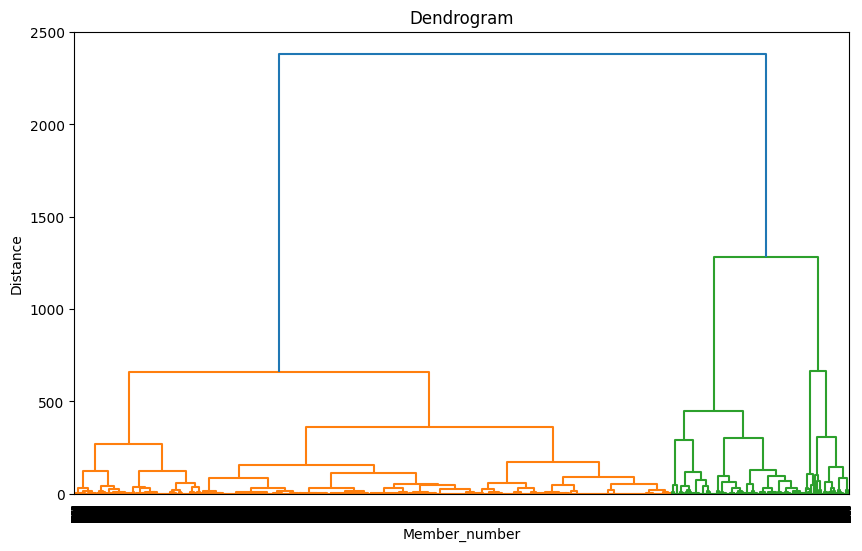

In [64]:
# Tạo ma trận khoảng cách
distance_matrix = df[['items', 'price', 'Sales']].values

# Xây dựng cây phân cấp
linkage_matrix = linkage(distance_matrix, method='ward')

# Vẽ dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=df['Member_number'].values)
plt.xlabel('Member_number')
plt.ylabel('Distance')
plt.title('Dendrogram')
plt.show()

In [65]:
# Chọn số cụm dựa trên dendrogram
num_clusters = 4  # Số cụm bạn muốn chọn
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Thêm cột cluster vào dataframe
df['cluster'] = cluster_labels

In [66]:
df.head()

Member_number       Date  productId  items       productName     price  \
0           1808 2015-07-21          1      3    tropical fruit  7.803532   
1           2552 2015-01-05          2      1        whole milk  1.800000   
2           2300 2015-09-19          3      3         pip fruit  3.000000   
3           1187 2015-12-12          4      3  other vegetables  0.800000   
4           3037 2015-02-01          2      1        whole milk  1.800000   

       Sales  Transaction_id  Year  Sales_scaled  cluster  
0  23.410597               0  2015      0.271251        2  
1   1.800000               1  2015      0.017606        1  
2   9.000000               2  2015      0.102113        1  
3   2.400000               3  2015      0.024648        1  
4   1.800000               4  2015      0.017606        1

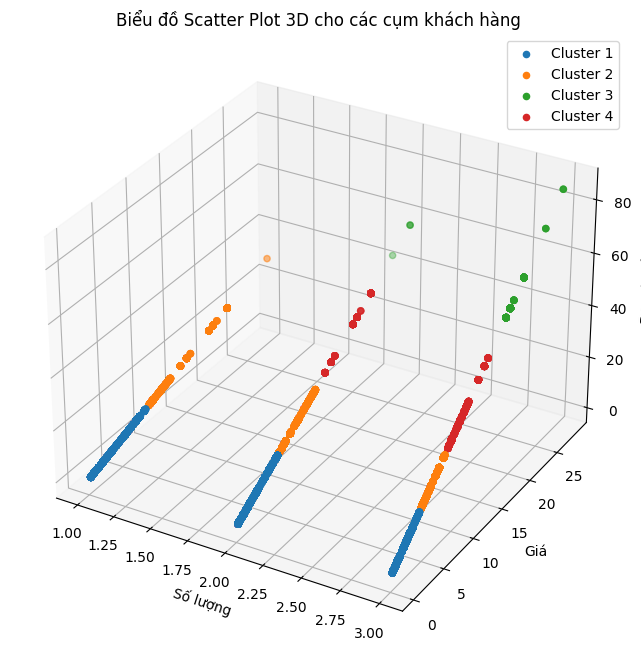

In [67]:
# Vẽ biểu đồ scatter plot 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for cluster_id in np.unique(df['cluster']):
    cluster_data = df[df['cluster'] == cluster_id]
    ax.scatter(cluster_data['items'], cluster_data['price'], cluster_data['Sales'], label=f'Cluster {cluster_id}')

ax.set_xlabel('Số lượng')
ax.set_ylabel('Giá')
ax.set_zlabel('Doanh số')

plt.title('Biểu đồ Scatter Plot 3D cho các cụm khách hàng')
plt.legend()
plt.show()

#### Các cụm phân tách rõ ràng

## 3.d. RFM + KMeans (LDS9)

In [68]:
import findspark
findspark.init()
import pyspark

In [69]:
from pyspark import SparkContext
SparkContext.setSystemProperty('spark.hadoop.dfs.client.use.datanode.hostname', 'true')
sc = SparkContext(master="local", appName="New Spark Context")

In [70]:
import pyspark.sql.functions as f
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from pyspark.sql import types
from pyspark.sql.types import *

In [71]:
spark = SparkSession(sc)

In [72]:
# Loads data.
data = spark.createDataFrame(df)

In [73]:
data = data.select(['items', 'price', 'Sales'])

In [74]:
data.show(3)

+-----+-----------+------------+
|items|      price|       Sales|
+-----+-----------+------------+
|    3|7.803532318|23.410596954|
|    1|        1.8|         1.8|
|    3|        3.0|         9.0|
+-----+-----------+------------+
only showing top 3 rows



In [75]:
# Format from data
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [76]:
vec_assembler = VectorAssembler(inputCols = data.columns, outputCol='features')

In [77]:
final_data = vec_assembler.transform(data)

In [78]:
#Scale the Data
from pyspark.ml.feature import StandardScaler

In [79]:
scaler = StandardScaler(inputCol="features", 
                        outputCol="scaledFeatures", 
                        withStd=True, 
                        withMean=False)

In [80]:
# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(final_data)

In [81]:
# Normalize each feature to have unit standard deviation.
final_data = scalerModel.transform(final_data)

In [82]:
#Train the Model and Evaluate
from pyspark.ml.clustering import KMeans, KMeansModel

In [83]:
#Trains a k-means model.
k_list = []
wssse_list = []
for k in range(2,11): 
    kmeans = KMeans(featuresCol='scaledFeatures',k=k)
    model = kmeans.fit(final_data)
    wssse = model.summary.trainingCost
    k_list.append(k)
    wssse_list.append(wssse)
    print("With k =", k, "Set Sum of Squared Errors = " + str(wssse))

With k = 2 Set Sum of Squared Errors = 66440.73023034522
With k = 3 Set Sum of Squared Errors = 42086.36956989848
With k = 4 Set Sum of Squared Errors = 30561.21213855295
With k = 5 Set Sum of Squared Errors = 24260.08851794318
With k = 6 Set Sum of Squared Errors = 16669.615871546786
With k = 7 Set Sum of Squared Errors = 13867.821389600183
With k = 8 Set Sum of Squared Errors = 11152.229437002354
With k = 9 Set Sum of Squared Errors = 8487.95884770875
With k = 10 Set Sum of Squared Errors = 7072.804259400391


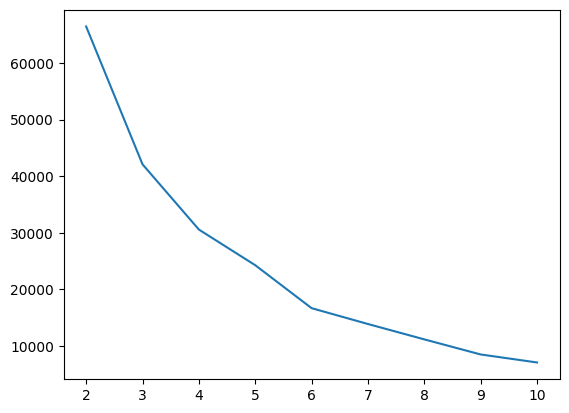

In [84]:
plt.plot(k_list, wssse_list)
plt.show()

In [85]:
# Select k = 4
# Trains a k-means model.
kmeans = KMeans(featuresCol='scaledFeatures',k=4)
model = kmeans.fit(final_data)

In [86]:
# Evaluate clustering by computing Within Set Sum of Squared Errors.
wssse = model.summary.trainingCost
print("Within Set Sum of Squared Errors = " + str(wssse))

Within Set Sum of Squared Errors = 30561.21213855295


In [87]:
predictions = model.transform(final_data)

In [88]:
# Check number points of each cluster
predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|11796|
|         3| 2103|
|         2|17506|
|         0| 7360|
+----------+-----+



In [89]:
data_result = predictions.select("prediction")
data_result.columns

['prediction']

In [90]:
temp = final_data.select("scaledFeatures").rdd.map(lambda x: \
 x[0].toArray().tolist()).toDF()

In [91]:
# since there is no common column between these two dataframes add row_index so t
temp=temp.withColumn('row_index', f.monotonically_increasing_id())
data_result=data_result.withColumn('row_index', 
                                   f.monotonically_increasing_id())
temp = temp.join(data_result, 
                 on=["row_index"]).sort("row_index").drop("row_index")

In [92]:
temp = temp.select(col("_1").alias("items_scale"), 
                   col("_2").alias("price_scale"), 
                   col("_3").alias("Sales_scale"), 
                   "prediction")

In [93]:
df = temp.toPandas()

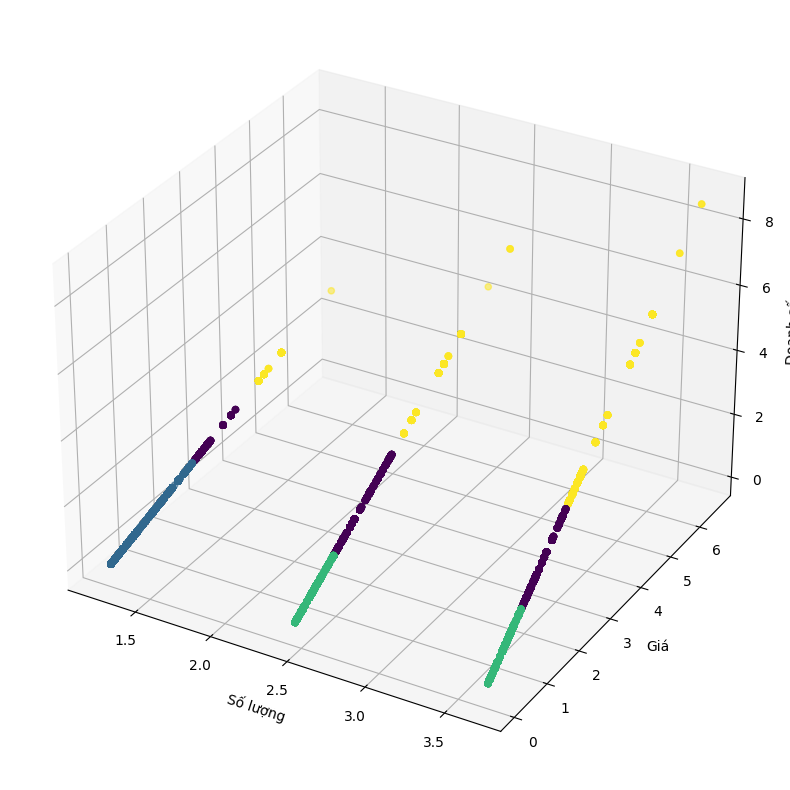

In [94]:
fig = plt.figure(figsize=(12, 10))
threedee = fig.add_subplot(111, projection='3d')
threedee.scatter(df.items_scale, df.price_scale, 
                 df.Sales_scale, 
                 c=df.prediction)
threedee.set_xlabel('Số lượng')
threedee.set_ylabel('Giá')
threedee.set_zlabel('Doanh số')
plt.show()

#### Các cụm phân tách khá rõ ràng

### CONCLUSION

### Qua các model trên -> Chọn model Kmeans LDS6 vì các cụm phân tách rõ ràng, đồng thời dễ dàng chạy trên các nền tạo App

In [69]:
from sklearn.cluster import KMeans
# Build model with k=5
choose_model = KMeans(n_clusters=5, random_state=42)

### Save model

In [70]:
import pickle
pkl_filename = 'cus_segment_model.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(choose_model, file)

## 4. App Streamlit

In [71]:
## Run file py

In [72]:
df_cust = df.merge(df_now[['Member_number','CustGroup']], on='Member_number', how='left')
df_cust.head()

Member_number       Date  productId  items       productName     price  \
0           1808 2015-07-21          1      3    tropical fruit  7.803532   
1           2552 2015-01-05          2      1        whole milk  1.800000   
2           2300 2015-09-19          3      3         pip fruit  3.000000   
3           1187 2015-12-12          4      3  other vegetables  0.800000   
4           3037 2015-02-01          2      1        whole milk  1.800000   

       Sales  Transaction_id  Year  Sales_scaled CustGroup  
0  23.410597               0  2015      0.271251     LOYAL  
1   1.800000               1  2015      0.017606  REGULARS  
2   9.000000               2  2015      0.102113       NEW  
3   2.400000               3  2015      0.024648       NEW  
4   1.800000               4  2015      0.017606  REGULARS

In [73]:
def top_product(cust_group):

    df_top = pd.DataFrame(
        df_cust.loc[df_cust['CustGroup']== cust_group]
        .groupby(['productName','price']).count()['productId']
        .sort_values(ascending=False).head(20)).reset_index()

    def text_underthesea(text):
        products_wt = text.str.lower().apply(lambda x: word_tokenize(x, format="text"))
        products_name_pre = [[text for text in set(x.split())] for x in products_wt]
        products_name_pre = [[re.sub('[0-9]+','', e) for e in text] for text in products_name_pre]
        products_name_pre = [[t.lower() for t in text if not t in ['', ' ', ',', '.', '...', '-',':', ';', '?', '%', '_%' , '(', ')', '+', '/', 'g', 'ml']]
                            for text in products_name_pre] # ký tự đặc biệt
        products_name_pre = [[t for t in text if not t in stop_words] for text in products_name_pre] # stopword

        return products_name_pre

    def wcloud_visualize(input_text):
        flat_text = [word for sublist in input_text for word in sublist]
        text = ' '.join(flat_text)

        wc = WordCloud(
                    background_color='black',
                    colormap='twilight_shifted_r',
                    max_words=50,
                    width=1600,
                    height=900,
                    max_font_size=400)
        wc.generate(text)

        plt.figure(figsize=(8,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.show()

    token_description =  text_underthesea(df_top['productName'])
    print("Top 5 products choosen by Group of ",cust_group,':\n')
    wcloud_visualize(token_description)    

    return df_top.head()

Top 5 products choosen by Group of  VIP :



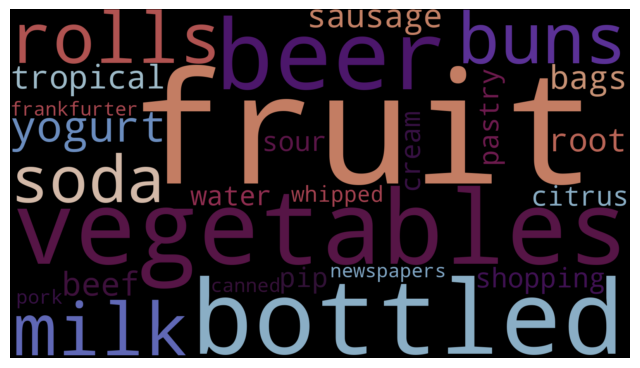

********************
Top 5 products choosen by Group of  LOYAL :



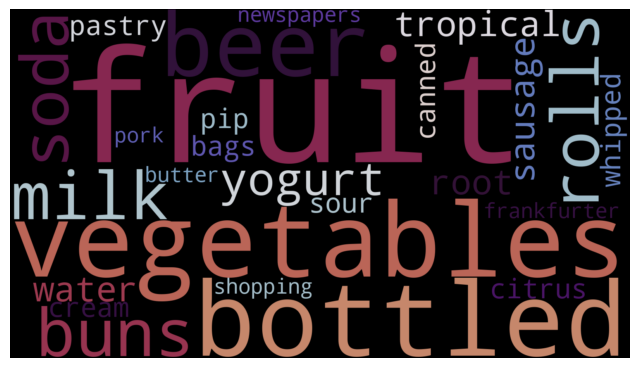

********************
Top 5 products choosen by Group of  NEW :



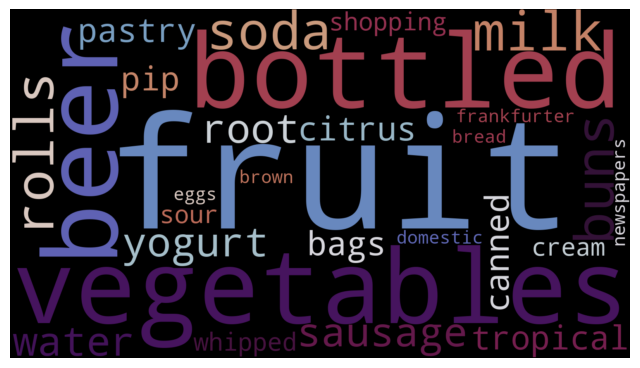

********************
Top 5 products choosen by Group of  REGULARS :



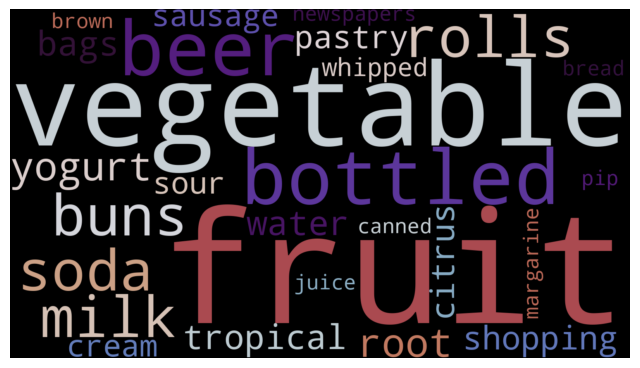

********************
Top 5 products choosen by Group of  LOST :



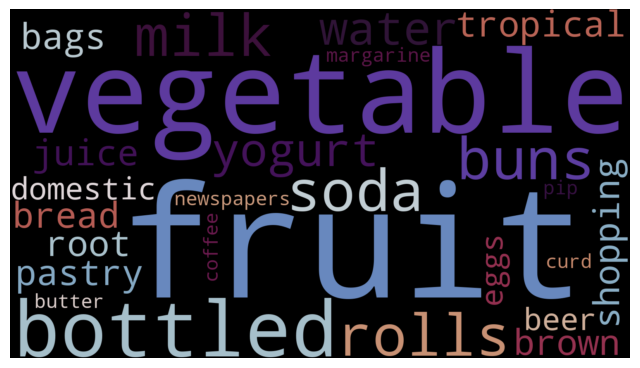

********************


In [74]:
user_selects = ['VIP','LOYAL','NEW','REGULARS', 'LOST']
for name in user_selects:
    top_product(name)
    print('*'*20)